# Baseline

**Proyecto Integrador TC5035.10**

**Profesor Asesor:**
- Dra. Ludivina Facundo (ITESM)


**Profesores Investigadores/Tutores:**
- Dr. Juan Arturo Nolazco (ITESM)
- Dr. Marcos Faunez Zaunuy (TecnoCampus Barcelona)

**Equipo 11:**
- Francisco José Arellano Montes (A01794283)
- Armando Bringas Corpus (A01200230)
- Moisés Díaz Malagón (A01208580)

Este avance consiste en construir un modelo de referencia que permita evaluar la viabilidad del problema. Si el baseline tiene un rendimiento similar al azar, podría indicar que el problema es intrínsecamente difícil o que los datos no contienen suficiente información para predecir el objetivo. De lo contrario, el baseline podría como una solución mínima aceptable cuando se trabaja en escenarios donde incluso un modelo simple puede proporcionar valor.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve, det_curve
from xgboost import XGBClassifier


In [2]:
def cargar_datos():
    """
    Carga los datos preprocesados del análisis exploratorio
    """
    X_train = pd.read_parquet('../data/preprocessed/X_train.parquet')
    y_train = pd.read_parquet('../data/preprocessed/y_train.parquet')
    X_val = pd.read_parquet('../data/preprocessed/X_val.parquet')
    y_val = pd.read_parquet('../data/preprocessed/y_val.parquet')
    X_test = pd.read_parquet('../data/preprocessed/X_test.parquet')
    y_test = pd.read_parquet('../data/preprocessed/y_test.parquet')
    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
X_train, y_train, X_val, y_val, X_text, y_test = cargar_datos()

In [4]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((571, 4), (571, 3), (556, 4), (556, 3))

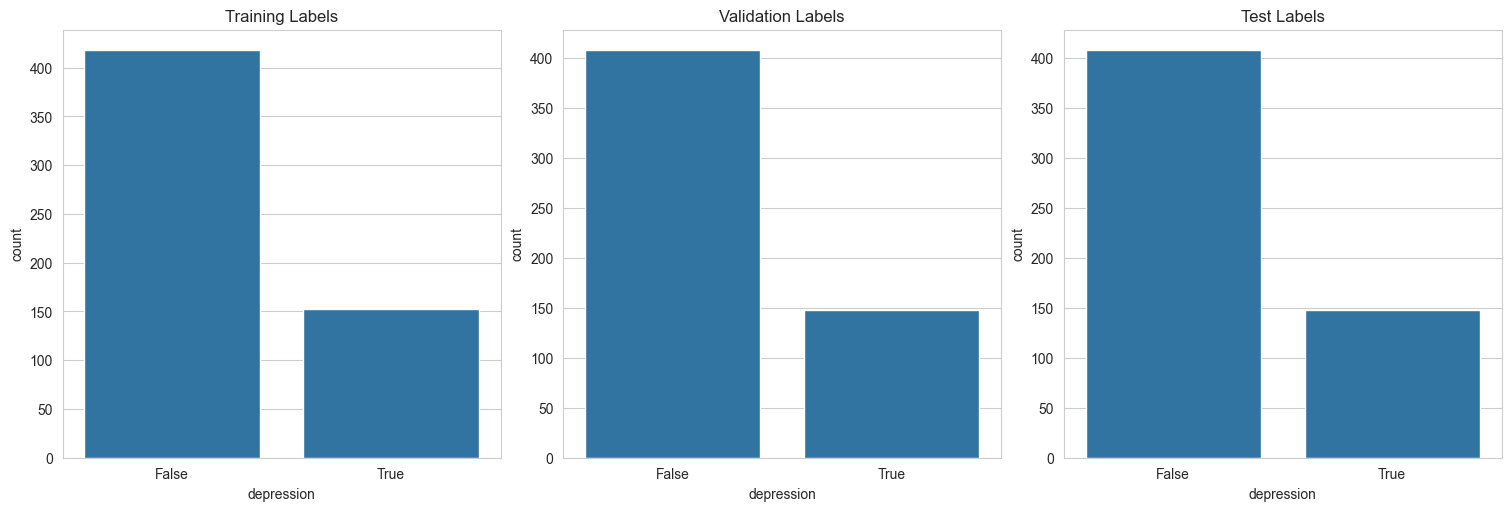

Proporción en train set: 0.27
Proporción en validation set: 0.27
Proporción en test set: 0.27


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)


sns.countplot(data=y_train, x='depression', ax=axes[0])
axes[0].set_title('Training Labels')
sns.countplot(data=y_val, x='depression', ax=axes[1])
axes[1].set_title('Validation Labels')

sns.countplot(data=y_test, x='depression', ax=axes[2])
axes[2].set_title('Test Labels')


plt.show()

print(f'Proporción en train set: {y_train["depression"].mean():.2f}')
print(f'Proporción en validation set: {y_val["depression"].mean():.2f}')
print(f'Proporción en test set: {y_test["depression"].mean():.2f}')

Primeramente podemos comprobar que se mantiene el balancen de clases en los 3 sets de datos, entrenamiento, validación y prueba para la etiqueta 'depression'.


TODO: poner el de las otras dos labels


# Análisis de balance de clases

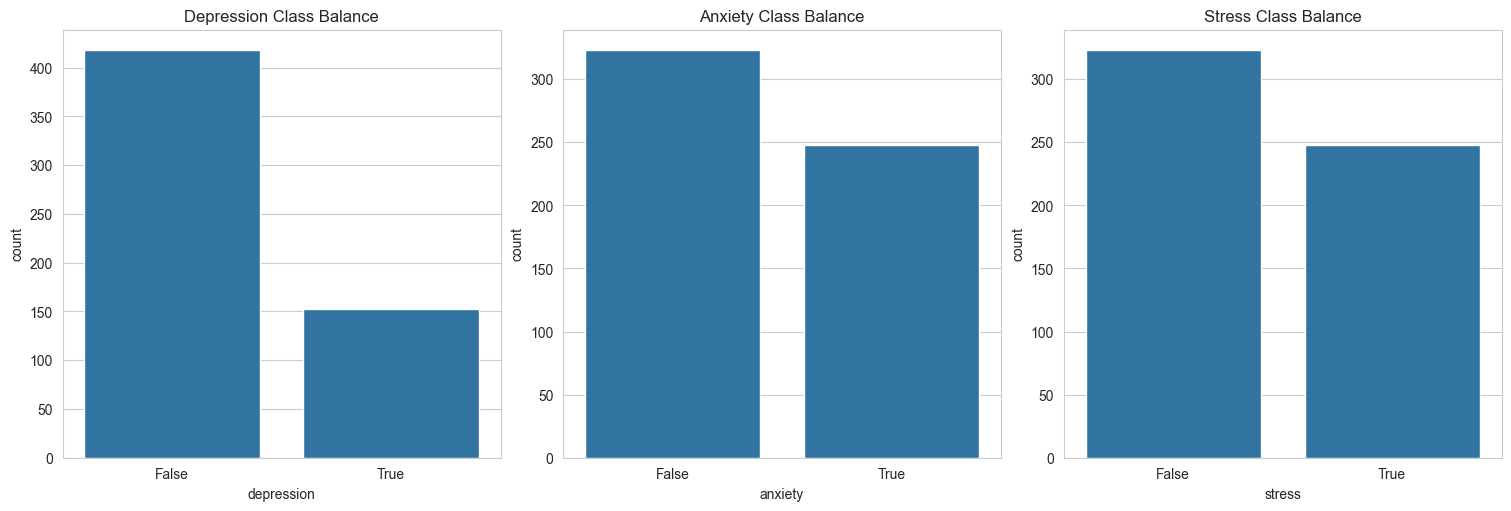

Porcentaje de la clase positiva de Depression: 0.27
Porcentaje de la clase positiva de Anxiety: 0.43
Porcentaje de la clase positiva de Stress: 0.43


In [6]:
# Set up the figure with 3 subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
sns.countplot(data=y_train, x='depression', ax=axes[0])
axes[0].set_title('Depression Class Balance')
sns.countplot(data=y_train, x='anxiety', ax=axes[1])
axes[1].set_title('Anxiety Class Balance')
sns.countplot(data=y_train, x='stress', ax=axes[2])
axes[2].set_title('Stress Class Balance')
plt.show()

# Print proportions
print(f'Porcentaje de la clase positiva de Depression: {y_train["depression"].mean():.2f}')
print(f'Porcentaje de la clase positiva de Anxiety: {y_train["anxiety"].mean():.2f}')
print(f'Porcentaje de la clase positiva de Stress: {y_train["stress"].mean():.2f}')


Dado que se trabajará como 3 problemas de clasificación binaria independientes, se puede comprobar que no tenemos un problema de datos no balanceados pues para las 3 variables estamos dentro de un 80/20 de proporciones entre la clase negativa y la positiva para cada label.

Con el balance de clases positivas, se establece el desempeño mínimo a obtener para verificar que el modelo baseline no está sub-entrenado.

In [7]:
print(f"Expected minimum accuracy for depression: {y_train['depression'].mean():.4f}")
print(f"Expected minimuma ccuracy for anxiety: {y_train['anxiety'].mean():.4f}")
print(f"Expected minimum accuracy for stress: {y_train['stress'].mean():.4f}")

Expected minimum accuracy for depression: 0.2680
Expected minimuma ccuracy for anxiety: 0.4343
Expected minimum accuracy for stress: 0.4343


# Métrica

Dado que se trabajará con un 3 problemas independientes de clasificación binaria, se utilizarán las siguientes métricas:
TODO: Completar descripción, y justificar el por qué de cada una. E.g. f1 para clases no tan balanceadas. 

- accuracy:
- precision:
- recall:
- f1:
- roc_auc:

De acuerdo con el contexto de negocio, que es el diagnóstico psicológico y considerando el factor de la sugestión, será importante reducir la cantidad de Falsos Positivos (error tipo 1) que significa que queremos reducir el número de casos donde le decimos a un paciente que tiene depresión cuando en realidad no lo tiene. Por lo tanto la métrica a optimizar será precision. 

TODO: definir con los doctores


De acuerdo con el balanceo de clases, ya que se cuenta con una mínima proporcion que no supera el 80/20 podemos decir que no se esperan afectaciones en el aprendizaje para la clase minoritaria (positiva), sin embargo si es necesario en la siguiente mejora del modelo se utilizarán técnicas de balanceo de clase al menos para el caso de "depression".

# Algoritmo y entrenamiento

¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?

[TODO: Se explica por qué el algoritmo seleccionado es apropiado para el tipo de problema que se está abordando. Se considera en el análisis aspectos clave, como el tipo (estructurados o no estructurados) y la cantidad de datos, la presencia de características relevantes, la interpretabilidad (si es importante), entre otros.]


### Preparación de 'features' para 'depression', 'anxiety' y 'stress'

In [8]:
features_x_train = pd.DataFrame(X_train['caracteristica_0'].to_list())
features_y_train = pd.DataFrame(X_train['caracteristica_1'].to_list())
all_features_train = pd.concat([features_x_train, features_y_train], axis=1)
all_features_train.columns = [f"feature_{i}" for i in range(all_features_train.shape[1])]

features_x_val = pd.DataFrame(X_val['caracteristica_0'].to_list())
features_y_val = pd.DataFrame(X_val['caracteristica_1'].to_list())
all_features_val = pd.concat([features_x_val, features_y_val], axis=1)
all_features_val.columns = [f"feature_{i}" for i in range(all_features_val.shape[1])]


In [9]:
all_features_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
0,-0.001141,0.001778,-0.000225,-0.018490,0.008358,-0.003956,-0.001141,0.001778,-0.000225,-0.018490,0.008358,-0.003956
1,-0.009949,0.007753,-0.002964,0.004642,0.040384,0.009501,-0.009949,0.007753,-0.002964,0.004642,0.040384,0.009501
2,-0.001141,0.001778,-0.000225,-0.018490,0.008358,-0.003956,-0.001141,0.001778,-0.000225,-0.018490,0.008358,-0.003956
3,-0.000798,-0.006673,-0.013066,-0.060550,-0.002632,-0.033502,-0.000798,-0.006673,-0.013066,-0.060550,-0.002632,-0.033502
4,-0.011365,0.058803,0.009939,-0.056347,-0.005695,-0.026979,-0.011365,0.058803,0.009939,-0.056347,-0.005695,-0.026979


In [10]:
all_features_val.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
0,0.028198,0.003056,-0.053527,-0.040464,0.058109,0.049808,0.028198,0.003056,-0.053527,-0.040464,0.058109,0.049808
1,0.059412,-0.026258,-0.093515,0.009559,-0.047513,-0.059090,0.059412,-0.026258,-0.093515,0.009559,-0.047513,-0.059090
2,0.082506,-0.071859,-0.163757,0.019404,-0.040100,-0.131935,0.082506,-0.071859,-0.163757,0.019404,-0.040100,-0.131935
3,-0.028263,-0.012318,-0.003904,-0.078606,-0.039678,0.012166,-0.028263,-0.012318,-0.003904,-0.078606,-0.039678,0.012166
4,0.031886,0.028093,-0.009794,-0.002176,-0.056350,0.027733,0.031886,0.028093,-0.009794,-0.002176,-0.056350,0.027733


### Logistic Regression

In [11]:
log_model = LogisticRegression(class_weight='balanced', random_state=42)
log_model.fit(all_features_train, y_train['depression'])
y_pred_depression = log_model.predict(all_features_val)

print("Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_depression))
print("Depression ROC AUC:", roc_auc_score(y_val['depression'], y_pred_depression))

# Anxiety
log_model.fit(all_features_train, y_train['anxiety'])
y_pred_anxiety = log_model.predict(all_features_val)
print("\nAnxiety Classification Report:")
print(classification_report(y_val['anxiety'], y_pred_anxiety))
print("Anxiety ROC AUC:", roc_auc_score(y_val['anxiety'], y_pred_anxiety))

# Stress
log_model.fit(all_features_train, y_train['stress'])
y_pred_stress = log_model.predict(all_features_val)
print("\nStress Classification Report:")
print(classification_report(y_val['stress'], y_pred_stress))
print("Stress ROC AUC:", roc_auc_score(y_val['stress'], y_pred_stress))


Depression Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.04      0.08       408
        True       0.27      0.95      0.42       148

    accuracy                           0.29       556
   macro avg       0.49      0.50      0.25       556
weighted avg       0.60      0.29      0.17       556

Depression ROC AUC: 0.4984101748807631

Anxiety Classification Report:
              precision    recall  f1-score   support

       False       0.58      0.62      0.60       317
        True       0.44      0.40      0.42       239

    accuracy                           0.52       556
   macro avg       0.51      0.51      0.51       556
weighted avg       0.52      0.52      0.52       556

Anxiety ROC AUC: 0.5078930348587041

Stress Classification Report:
              precision    recall  f1-score   support

       False       0.55      0.37      0.45       315
        True       0.43      0.61      0.50       241

    accura

In [12]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(all_features_train, y_train['depression'])

log_model.fit(X_smote, y_smote)
y_pred_smote = log_model.predict(all_features_val)

print("SMOTE Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_smote))
print("SMOTE Depression ROC AUC:", roc_auc_score(y_val['depression'], y_pred_smote))


SMOTE Depression Classification Report:
              precision    recall  f1-score   support

       False       0.69      0.07      0.12       408
        True       0.26      0.92      0.41       148

    accuracy                           0.29       556
   macro avg       0.48      0.49      0.26       556
weighted avg       0.58      0.29      0.20       556

SMOTE Depression ROC AUC: 0.49254769475357707


In [13]:
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Oversample to 50% of the majority class
X_smote, y_smote = smote.fit_resample(all_features_train, y_train['depression'])

log_model.fit(X_smote, y_smote)
y_pred_smote = log_model.predict(all_features_val)

print("Refined SMOTE Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_smote))
print("Refined SMOTE Depression ROC AUC:", roc_auc_score(y_val['depression'], y_pred_smote))


Refined SMOTE Depression Classification Report:
              precision    recall  f1-score   support

       False       0.69      0.07      0.12       408
        True       0.26      0.92      0.41       148

    accuracy                           0.29       556
   macro avg       0.48      0.49      0.26       556
weighted avg       0.58      0.29      0.20       556

Refined SMOTE Depression ROC AUC: 0.49254769475357707


In [14]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42), 
                           param_grid, scoring='roc_auc', cv=5)

grid_search.fit(all_features_train, y_train['depression'])

best_model = grid_search.best_estimator_
y_pred = best_model.predict(all_features_val)

print("Tuned Logistic Regression Depression Report:")
print(classification_report(y_val['depression'], y_pred))
print("Tuned Logistic Regression ROC AUC:", roc_auc_score(y_val['depression'], y_pred))


Tuned Logistic Regression Depression Report:
              precision    recall  f1-score   support

       False       0.74      0.19      0.30       408
        True       0.27      0.82      0.40       148

    accuracy                           0.36       556
   macro avg       0.50      0.50      0.35       556
weighted avg       0.61      0.36      0.33       556

Tuned Logistic Regression ROC AUC: 0.503146528881823


### SVM (Support Vector Machine)

In [15]:
# Define the SVM model
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Only relevant for RBF kernel
}

grid_search = GridSearchCV(
    svm_model, param_grid, scoring='roc_auc', cv=3, verbose=1
)

grid_search.fit(all_features_train, y_train['depression'])
best_svm_model = grid_search.best_estimator_

y_pred_svm = best_svm_model.predict(all_features_val)
y_prob_svm = best_svm_model.predict_proba(all_features_val)[:, 1]  # Probabilities for ROC/PR

# Classification report
print("SVM Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_svm))

# ROC-AUC
roc_auc = roc_auc_score(y_val['depression'], y_prob_svm)
print("SVM Depression ROC AUC:", roc_auc)

precision, recall, _ = precision_recall_curve(y_val['depression'], y_prob_svm)
pr_auc = auc(recall, precision)
print("SVM Depression Precision-Recall AUC:", pr_auc)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.24      0.36       408
        True       0.26      0.73      0.38       148

    accuracy                           0.37       556
   macro avg       0.48      0.48      0.37       556
weighted avg       0.59      0.37      0.37       556

SVM Depression ROC AUC: 0.48828332008479064
SVM Depression Precision-Recall AUC: 0.2592049688174512


In [16]:
svm_poly = SVC(kernel='poly', degree=3, class_weight='balanced', probability=True, random_state=42)
svm_poly.fit(all_features_train, y_train['depression'])

y_pred_poly = svm_poly.predict(all_features_val)
y_prob_poly = svm_poly.predict_proba(all_features_val)[:, 1]

print("SVM (Poly) Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_poly))
print("SVM (Poly) Depression ROC AUC:", roc_auc_score(y_val['depression'], y_prob_poly))


SVM (Poly) Depression Classification Report:
              precision    recall  f1-score   support

       False       0.70      0.06      0.12       408
        True       0.26      0.93      0.41       148

    accuracy                           0.29       556
   macro avg       0.48      0.49      0.26       556
weighted avg       0.59      0.29      0.20       556

SVM (Poly) Depression ROC AUC: 0.4873476417594064


### XGBoost

In [17]:

# Compute class imbalance ratio
imbalance_ratio = len(y_train['depression'][y_train['depression'] == 0]) / len(y_train['depression'][y_train['depression'] == 1])

# Initialize XGBoost with imbalance handling
xgb_model = XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42)

# Train on depression classification
xgb_model.fit(all_features_train, y_train['depression'])

# Predict on validation set
y_pred_xgb = xgb_model.predict(all_features_val)
y_prob_xgb = xgb_model.predict_proba(all_features_val)[:, 1]

# Evaluate performance
print("XGBoost Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_xgb))
print("XGBoost Depression ROC AUC:", roc_auc_score(y_val['depression'], y_prob_xgb))


XGBoost Depression Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.35      0.48       408
        True       0.27      0.66      0.38       148

    accuracy                           0.43       556
   macro avg       0.50      0.50      0.43       556
weighted avg       0.61      0.43      0.45       556

XGBoost Depression ROC AUC: 0.5075268282988871


In [18]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size
    'scale_pos_weight': [imbalance_ratio]  # Imbalance handling
}

xgb_tuned = XGBClassifier(random_state=42)

grid_search = GridSearchCV(xgb_tuned, param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(all_features_train, y_train['depression'])

best_xgb = grid_search.best_estimator_

y_pred_xgb_tuned = best_xgb.predict(all_features_val)
y_prob_xgb_tuned = best_xgb.predict_proba(all_features_val)[:, 1]

print("Tuned XGBoost Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_xgb_tuned))
print("Tuned XGBoost Depression ROC AUC:", roc_auc_score(y_val['depression'], y_prob_xgb_tuned))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Tuned XGBoost Depression Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.04      0.07       408
        True       0.27      0.97      0.42       148

    accuracy                           0.29       556
   macro avg       0.53      0.50      0.25       556
weighted avg       0.65      0.29      0.16       556

Tuned XGBoost Depression ROC AUC: 0.5144988738738738


### LightGBM

In [19]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)
lgbm_model.fit(all_features_train, y_train['depression'])

y_pred_lgbm = lgbm_model.predict(all_features_val)
y_prob_lgbm = lgbm_model.predict_proba(all_features_val)[:, 1]

print("LightGBM Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_lgbm))
print("LightGBM Depression ROC AUC:", roc_auc_score(y_val['depression'], y_prob_lgbm))


LightGBM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.42      0.53       408
        True       0.26      0.55      0.35       148

    accuracy                           0.45       556
   macro avg       0.49      0.49      0.44       556
weighted avg       0.60      0.45      0.48       556

LightGBM Depression ROC AUC: 0.49295343137254904


In [20]:
param_grid = {
    'num_leaves': [20, 50, 100],  # Increase to capture complexity
    'learning_rate': [0.01, 0.1, 0.3],  # Adjust step size
    'min_child_samples': [5, 10, 20],  # Control leaf creation
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(LGBMClassifier(random_state=42, verbose=-1), param_grid, scoring='roc_auc', cv=3, verbose=1)
grid_search.fit(all_features_train, y_train['depression'])

best_lgbm = grid_search.best_estimator_

y_pred_lgbm_tuned = best_lgbm.predict(all_features_val)
y_prob_lgbm_tuned = best_lgbm.predict_proba(all_features_val)[:, 1]

print("Tuned LightGBM Depression Classification Report:")
print(classification_report(y_val['depression'], y_pred_lgbm_tuned))
print("Tuned LightGBM Depression ROC AUC:", roc_auc_score(y_val['depression'], y_prob_lgbm_tuned))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Tuned LightGBM Depression Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.41      0.52       408
        True       0.26      0.56      0.35       148

    accuracy                           0.45       556
   macro avg       0.49      0.49      0.44       556
weighted avg       0.60      0.45      0.48       556

Tuned LightGBM Depression ROC AUC: 0.4767074059353472


# Análisis de sub/sobreajuste

[TODO: Se comparan diferentes métricas de evaluación del modelo en los conjuntos de entrenamiento y prueba para concluir si hay sub/sobreajuste. Se pueden utilizar curvas de aprendizaje, técnicas de validación cruzada o inspección de gráficos de residuos para complementar el análisis.]

¿El modelo está sub/sobreajustando los datos de entrenamiento?

[tomar como referencia este análsis: No se observa sobre-entrenamiento pues la diferencia de accuracy entre test y train no es mayor al 3%. No se observa bajo-entrenamiento porque el porcentaje de accuracy es mayor a 0.56 que es el nuevo porcentaje de clase mayoritaria despues de las técnicas de bajo y sobre muestreo.]


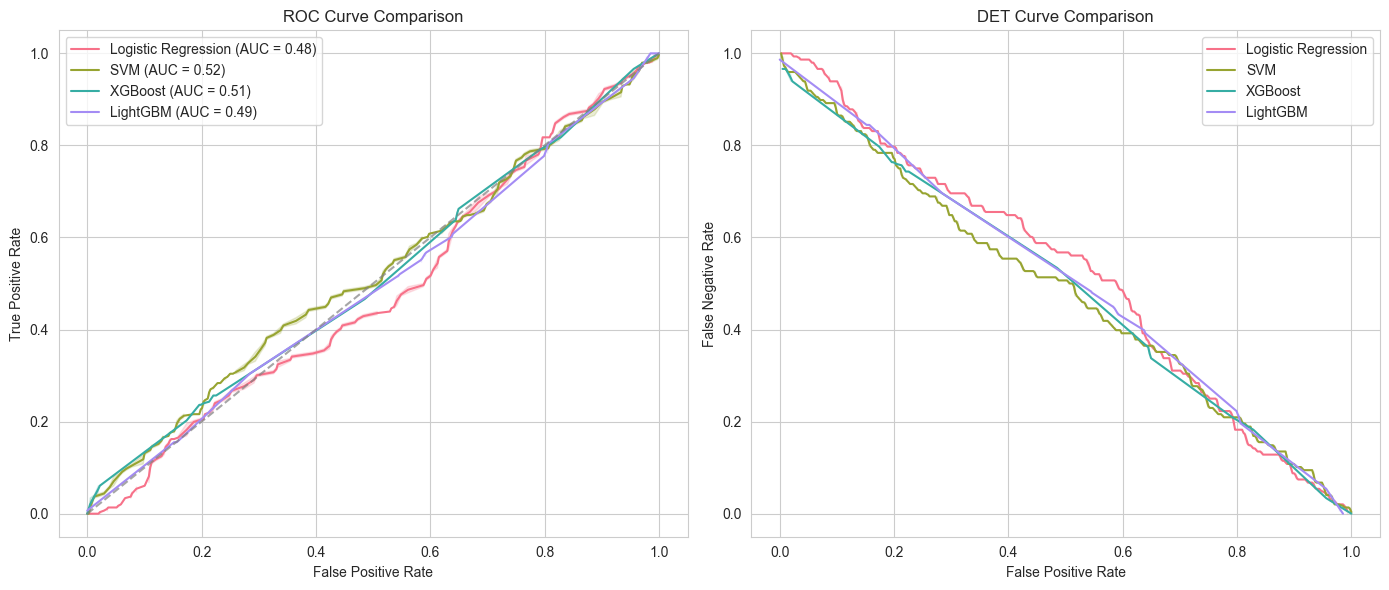

In [21]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=imbalance_ratio, random_state=42),
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42)
}

plt.figure(figsize=(14, 6))
palette = sns.color_palette("husl", len(models))


for i, (name, model) in enumerate(models.items()):
    model.fit(all_features_train, y_train['depression'])
    y_prob = model.predict_proba(all_features_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val['depression'], y_prob)
    fpr_det, fnr_det, _ = det_curve(y_val['depression'], y_prob)
    plt.subplot(1, 2, 1)
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC = {roc_auc_score(y_val['depression'], y_prob):.2f})",
                 color=palette[i])
    plt.subplot(1, 2, 2)
    sns.lineplot(x=fpr_det, y=fnr_det, label=name, color=palette[i])


plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()


plt.subplot(1, 2, 2)
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.title("DET Curve Comparison")
plt.legend()

plt.tight_layout()
plt.show()


# Análisis de características importantes

[Se hace un análisis de la relevancia de las características, si aplica, utilizando métodos de selección (filter, embedded, wrapper) o extracción de características (PCA, FA, …) Se incluye una representación visual del resultado para facilitar la interpretación.]



¿Se puede determinar la importancia de las características para el modelo generado? Recuerden que incluir características irrelevantes puede afectar negativamente el rendimiento del modelo y aumentar la complejidad sin beneficios sustanciales.


# Conclusiones

# Referencias